In [ ]:
from ultralytics import YOLO
import torch
import os
import shutil
import pandas as pd
import random
import csv
import cv2
import matplotlib.pyplot as plt
import yaml


🖼️ Visualisation de 6 images du split train


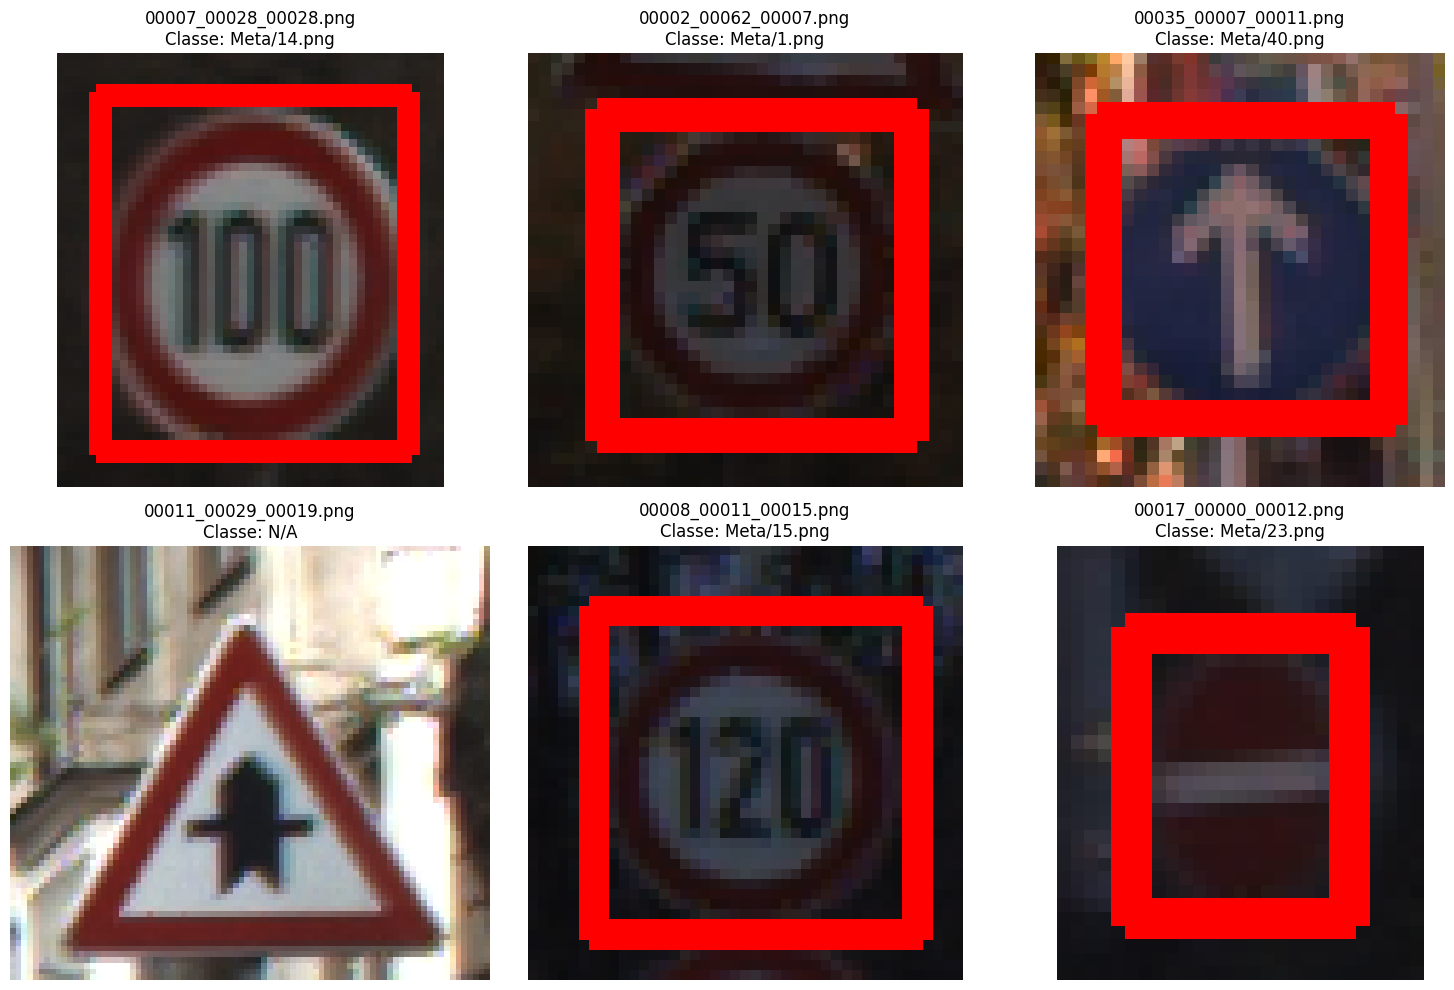

In [ ]:
DATA_YAML = r"panneaux\yolo_detection\dataset\data.yaml"
with open(DATA_YAML, 'r') as f:
    data_config = yaml.safe_load(f)


classes = data_config['names']

# images / labels
IMG_DIR = os.path.join(os.path.dirname(DATA_YAML), "images")
LABEL_DIR = os.path.join(os.path.dirname(DATA_YAML), "labels")

def visualize_yolo_annotations(split="train", num_samples=5):
   
    img_dir = os.path.join(IMG_DIR, split)
    label_dir = os.path.join(LABEL_DIR, split)
    
    # Obtenir quelques images
    image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    sample_images = random.sample(image_files, min(num_samples, len(image_files)))
    
    print(f"🖼️ Visualisation de {len(sample_images)} images du split {split}")
    
    # Ajuster le nombre de sous-plots automatiquement
    cols = 3
    rows = (len(sample_images) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    axes = axes.ravel()
    
    for idx, img_file in enumerate(sample_images):
        # Charger l'image
        img_path = os.path.join(img_dir, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]
        
        # Charger les annotations
        label_file = os.path.splitext(img_file)[0] + ".txt"
        label_path = os.path.join(label_dir, label_file)
        
        # Dessiner les bounding boxes
        class_name = "N/A"
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id, x_center, y_center, bbox_w, bbox_h = map(float, parts)
                        
                        # Convertir en coordonnees pixels
                        x_center_px = x_center * w
                        y_center_px = y_center * h
                        bbox_w_px = bbox_w * w
                        bbox_h_px = bbox_h * h
                        
                        # Calculer les coins
                        x1 = int(x_center_px - bbox_w_px / 2)
                        y1 = int(y_center_px - bbox_h_px / 2)
                        x2 = int(x_center_px + bbox_w_px / 2)
                        y2 = int(y_center_px + bbox_h_px / 2)
                        
                        # Dessiner le rectangle
                        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
                        
                        # Ajouter le label
                        class_name = classes[int(class_id)] if int(class_id) < len(classes) else str(int(class_id))
                        cv2.putText(image, class_name, (x1, y1-10), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        axes[idx].imshow(image)
        axes[idx].set_title(f"{img_file}\nClasse: {class_name}")
        axes[idx].axis('off')
    
    for idx in range(len(sample_images), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_yolo_annotations("train", 6)


In [ ]:

yaml_path = r"panneaux\yolo_detection\dataset\data.yaml"

def train_yolo_model():
    """Entraîner le modèle YOLO"""
    
    print("🚀 DÉBUT DE L'ENTRAÎNEMENT YOLO")
    print("=" * 40)
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"📊 Device utilisé: {device}")
    print(f"🎯 Fichier de configuration: {yaml_path}")
    
    model = YOLO('yolov8s.pt') 
    training_config = {
        'data': yaml_path,
        'epochs': 10,
        'imgsz': 640,
        'batch': 16,
        'workers': 4,
        'device': device,
        'patience': 10,
        'save': True,
        'exist_ok': True,
        'pretrained': True,
        'optimizer': 'AdamW',
        'lr0': 0.001,
        'lrf': 0.01,
        'momentum': 0.9,
        'weight_decay': 0.0001,
        'warmup_epochs': 3,
        'box': 7.5,
        'cls': 0.5,
        'dfl': 1.5,
        'close_mosaic': 10,
    }
    
    print("⚙️ Configuration d'entraînement:")
    for key, value in training_config.items():
        print(f"   {key}: {value}")
    
    # Démarrer l'entraînement
    results = model.train(**training_config)
    
    print("✅ Entraînement terminé!")
    return model, results


model, results = train_yolo_model()

🚀 DÉBUT DE L'ENTRAÎNEMENT YOLO
📊 Device utilisé: cpu
🎯 Fichier de configuration: D:\sara_projects\projets\panneaux\yolo_detection\dataset\data.yaml
⚙️ Configuration d'entraînement:
   data: D:\sara_projects\projets\panneaux\yolo_detection\dataset\data.yaml
   epochs: 10
   imgsz: 640
   batch: 16
   workers: 4
   device: cpu
   patience: 10
   save: True
   exist_ok: True
   pretrained: True
   optimizer: AdamW
   lr0: 0.001
   lrf: 0.01
   momentum: 0.9
   weight_decay: 0.0001
   warmup_epochs: 3
   box: 7.5
   cls: 0.5
   dfl: 1.5
   close_mosaic: 10
Ultralytics 8.3.223  Python-3.13.0 torch-2.9.0+cpu CPU (Intel Core i5-8350U 1.70GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\sara_projects\projets\panneaux\yolo_detection\dataset\data.yaml, degrees=0.0, de

In [24]:
def evaluate_model(model_path):
    model = YOLO(model_path)
    metrics = model.val(data=yaml_path)
 
    print("\n RESULTS:")
    print(f"   mAP50:    {metrics.box.map50:.4f}")
    print(f"   mAP50-95: {metrics.box.map:.4f}") 
    print(f"   PRECISION: {metrics.box.p:.4f}")
    print(f"   Rappel:    {metrics.box.r:.4f}")
    
    # Courbes de performance
    results_dir = "runs/detect/train"
    if os.path.exists(results_dir):
        results_files = os.listdir(results_dir)
        print(f"\n📁 Fichiers de résultats: {results_files}")
    
    return metrics
metrics = evaluate_model("runs/detect/train/weights/best.pt")
import matplotlib.pyplot as plt
plt.imshow(plt.imread(os.path.join(results_dir, "results.png")))
plt.axis('off')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'runs\\detect\\train\\weights\\best.pt'

In [ ]:
def test_detection(model_path, image_path, conf_threshold=0.25):
    model = YOLO(model_path)
    results = model(image_path, conf=conf_threshold)

    for r in results:
        im_array = r.plot() 
        im = Image.fromarray(im_array[..., ::-1]) 
        
        plt.figure(figsize=(12, 8))
        plt.imshow(im)
        plt.axis('off')
        plt.title(f"Detection sur {os.path.basename(image_path)}")
        plt.show()
        
        print(f"🎯 Panneaux detectes: {len(r.boxes)}")
        for box in r.boxes:
            class_id = int(box.cls[0])
            confidence = box.conf[0].item()
            class_name = model.names[class_id]
            print(f"   - {class_name}: {confidence:.3f}")
    
    return results

test_image_path = "chemin/vers/ton/image/test.jpg"
results = test_detection("runs/detect/train/weights/best.pt", test_image_path)

In [ ]:
def monitor_training():
    results_csv = "runs/detect/train/results.csv"
    
    if os.path.exists(results_csv):
        df = pd.read_csv(results_csv)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss box
        axes[0,0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
        axes[0,0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
        axes[0,0].set_title('Box Loss')
        axes[0,0].legend()
        
        # Loss cls
        axes[0,1].plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss')
        axes[0,1].plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss')
        axes[0,1].set_title('Classification Loss')
        axes[0,1].legend()
        
        # mAP
        axes[1,0].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50')
        axes[1,0].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95')
        axes[1,0].set_title('mAP Metrics')
        axes[1,0].legend()
        
        # Precision/Recall
        axes[1,1].plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
        axes[1,1].plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
        axes[1,1].set_title('Precision & Recall')
        axes[1,1].legend()
        
        plt.tight_layout()
        plt.show()
        
        print(f"last metric - mAP50: {df['metrics/mAP50(B)'].iloc[-1]:.3f}")
    else:
        print("Fichier non trouve")

monitor_training()

In [ ]:
model.save('traffic_sign_detector.pt')